#### Import the real (Reddit) conversations and synthetic (GPT-4 generated) conversations and run the Team Communication Toolkit featurizer
##### Note: this step takes 10+ hours to run if you are creating vectors. For this demo, we directly use features that have already been generated by us.

In [246]:
from team_comm_tools import FeatureBuilder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_1samp
from tqdm import tqdm
import pickle

from feature_lists import *

# Load in data and subsample with respect to confounders

## Raw inputs

In [247]:
gpt_data = pd.read_csv('input-files/gpt_data.csv')

In [248]:
df_awry = pd.read_csv('input-files/conversations_gone_awry.csv')
df_winning = pd.read_csv('input-files/winning_conversations.csv')
# filter out "ORIGINAL_POST" from df_winning
df_winning = df_winning[df_winning['reply_to'] != 'ORIGINAL_POST']
df_reddit_orig = pd.concat([df_winning, df_awry])

## Old TCT Outputs

In [249]:
# data = pd.read_csv('input-files/gpt_data.csv')
# data['message'] = data['message'].astype(str)

# feature_builder = FeatureBuilder(
# input_df =  data,
# custom_features = [
# "(BERT) Mimicry",
# "Moving Mimicry",
# "Forward Flow",
# "Discursive Diversity"],
# speaker_id_col = "speaker_nickname",
# message_col = "message",
# timestamp_col = "timestamp",
# vector_directory = "./vector_data/",
# output_file_base = "gpt_output"
# )

# feature_builder.featurize()

# Chat level features
reddit_chat_level_data = pd.read_csv('output/chat/combined_reddit_output_chat_level.csv')
gpt_chat_level_data = pd.read_csv('output/chat/gpt_output_chat_level.csv')

# Conversation level features
reddit_conv_level_data = pd.read_csv('output/conv/combined_reddit_output_conv_level.csv')
gpt_conv_level_data = pd.read_csv('output/conv/gpt_output_conv_level.csv')

compute_weights(reddit_chat_level_data)
compute_weights(gpt_chat_level_data)

reddit_combined = aggregate_chat_level_features(reddit_chat_level_data,reddit_conv_level_data)
gpt_combined = aggregate_chat_level_features(gpt_chat_level_data,gpt_conv_level_data)

## Distribution Checks

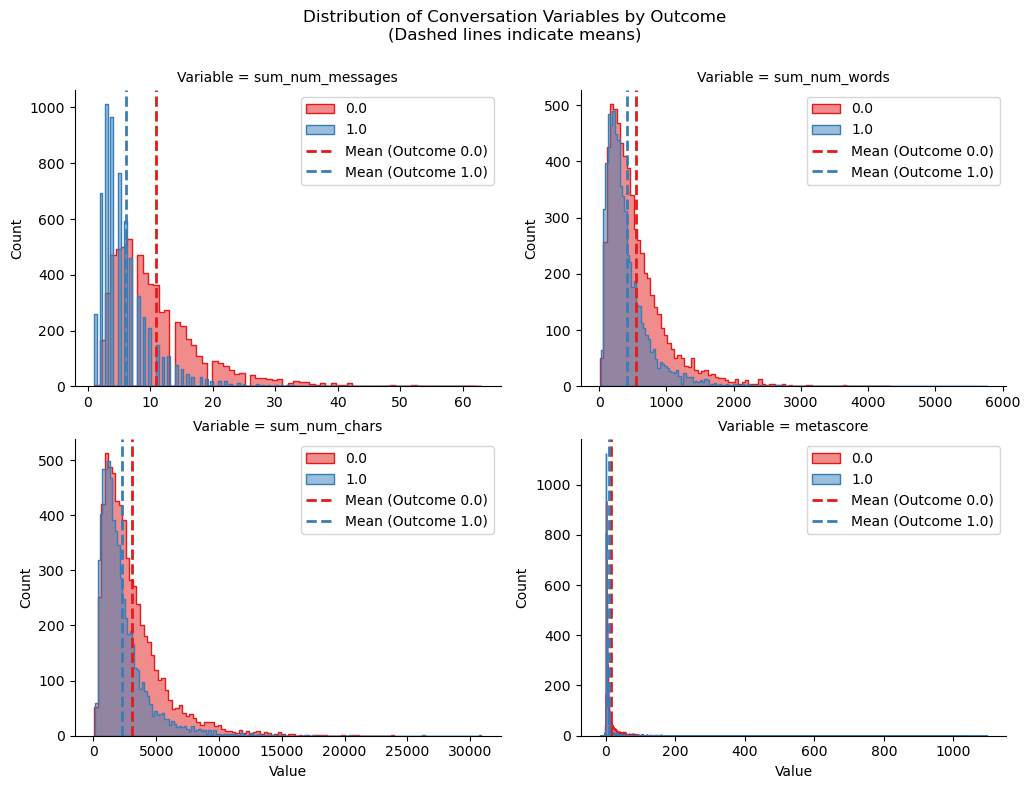

In [250]:
df_reddit_filtered = pd.read_csv('input-files/reddit_data.csv')
metascore_by_num = df_reddit_filtered[["conversation_num", "outcome", "metascore"]].drop_duplicates().groupby("conversation_num").mean().reset_index()


"""
Plot distributions: df_reddit_filtered was supposed to be filtered such that distributions are similar with respect to four
confounders, but empirically, this doesn't seem to be the case.

"""
def plot_confounder_distributions(df):
	 
	variables = ["sum_num_messages", "sum_num_words", "sum_num_chars", "metascore"]

	df_melt = df.melt(id_vars=['outcome'], value_vars=variables,
					var_name='Variable', value_name='Value')

	palette = sns.color_palette("Set1", n_colors=df['outcome'].nunique())

	g = sns.FacetGrid(df_melt, col="Variable", hue="outcome", col_wrap=2,
					sharex=False, sharey=False, height=4, aspect=1.3, palette=palette)
	g.map(sns.histplot, "Value", stat="count", alpha=0.5, element="step", kde=False)

	for variable, ax in zip(variables, g.axes.flat):
		for idx, outcome in enumerate(sorted(df['outcome'].unique())):
			vals = df.loc[df['outcome'] == outcome, variable]
			mean_val = vals.mean()
			ax.axvline(mean_val, color=palette[idx], linestyle='--', linewidth=2,
					label=f"Mean (Outcome {outcome})")
		# Remove duplicate legends
		handles, labels = ax.get_legend_handles_labels()
		by_label = dict(zip(labels, handles))
		ax.legend(by_label.values(), by_label.keys())

	plt.subplots_adjust(top=0.88)
	plt.suptitle("Distribution of Conversation Variables by Outcome\n(Dashed lines indicate means)")
	plt.show()

df_reddit_filtered_conv_metrics = reddit_combined[["conversation_num", "sum_num_messages", "sum_num_words", "sum_num_chars"]].merge(metascore_by_num, on ="conversation_num", how="left")
plot_confounder_distributions(df_reddit_filtered_conv_metrics)

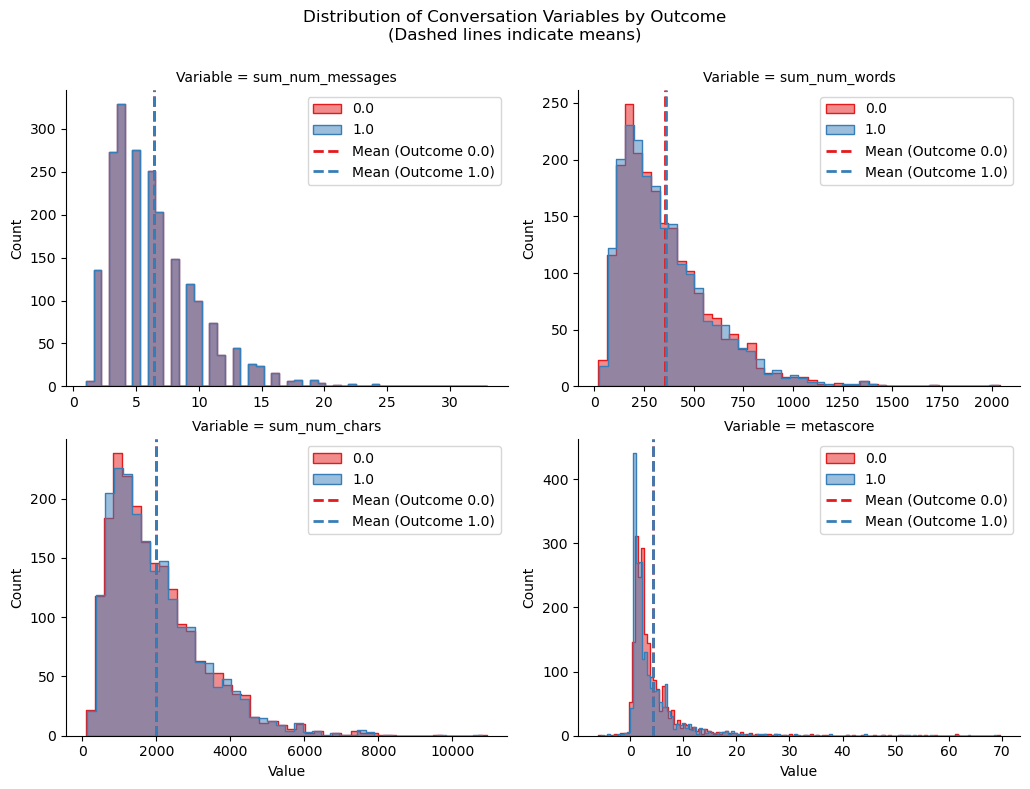

In [251]:
"""
Okay, let's fix the distributions by balancing the dataset with respect to these confounders.
"""

def balance_by_multivariable_bins_variable_width(df, variables, bin_widths, outcome_col='outcome', id_col='conversation_num', seed=42):
	np.random.seed(seed)
	df = df.copy()
	bin_cols = []
	for var in variables:
		width = bin_widths[var]
		bin_col = f"{var}_bin"
		df[bin_col] = (df[var] // width) * width
		bin_cols.append(bin_col)

	df["joint_bin"] = list(zip(*(df[col] for col in bin_cols)))

	sampled_ids = []
	grouped = df.groupby("joint_bin")
	for bin_val, group in grouped:
		group0 = group[group[outcome_col] == 0]
		group1 = group[group[outcome_col] == 1]
		min_count = min(len(group0), len(group1))
		if min_count > 0:
			samp_0 = np.random.choice(group0[id_col], size=min_count, replace=False)
			samp_1 = np.random.choice(group1[id_col], size=min_count, replace=False)
			sampled_ids.extend(samp_0)
			sampled_ids.extend(samp_1)

	balanced = df[df[id_col].isin(sampled_ids)].copy()
	balanced.drop(columns=bin_cols + ["joint_bin"], inplace=True)
	return balanced

variables = ["sum_num_messages", "sum_num_words", "sum_num_chars", "metascore"]
bin_widths = dict(df_reddit_filtered_conv_metrics[variables].describe().loc['std']/10)
df_reddit_balanced = balance_by_multivariable_bins_variable_width(
	df_reddit_filtered_conv_metrics,
	variables, bin_widths=bin_widths,
	outcome_col='outcome', id_col='conversation_num', seed=42
)

plot_confounder_distributions(df_reddit_balanced)

Make sure the dataset used for regression is also filtered

In [252]:
# now filter reddit data to only include conversations in the balanced dataset
reddit_combined = reddit_combined[reddit_combined['conversation_num'].isin(df_reddit_balanced['conversation_num'])]

### inspect the feature data

In [253]:
reddit_combined.sample(10)

,conversation_num,positive_bert,negative_bert,neutral_bert,num_words,num_chars,info_exchange_zscore_chats,discrepancies_lexical_wordcount,hear_lexical_wordcount,home_lexical_wordcount,...,gini_coefficient_sum_num_words,gini_coefficient_sum_num_chars,gini_coefficient_sum_num_messages,turn_taking_index,team_burstiness,info_diversity,discursive_diversity,variance_in_DD,incongruent_modulation,within_person_disc_range
1062,1557_A,0.046840,0.538995,0.414165,81.125000,464.875000,0.568242,1.625000,0.125000,0.000000,...,0.426040,0.432778,0.375000,0.142857,0.420204,0.633632,0.335474,0.000000,0.110707,1.160748
9782,dmxxb40,0.036500,0.506936,0.456565,53.000000,298.230769,-0.085466,0.615385,0.000000,0.307692,...,0.165457,0.159230,0.205128,0.416667,0.231348,0.413802,0.287744,0.006926,0.024412,1.431373
1194,1626_A,0.083934,0.506583,0.409483,62.117647,337.411765,0.155968,2.647059,0.235294,0.000000,...,0.179924,0.195432,0.088235,0.312500,0.424521,0.342313,0.276695,0.054926,0.024446,1.021173
8347,dbcnhb6,0.008499,0.815447,0.176054,52.250000,291.000000,-0.100886,0.750000,0.500000,0.250000,...,0.366029,0.375430,0.250000,0.666667,-0.149558,0.707999,0.715643,0.000000,0.123412,1.762469
6342,cuveca9,0.051933,0.473768,0.474299,97.000000,539.285714,1.014815,4.000000,0.000000,0.000000,...,0.464654,0.460000,0.357143,0.166667,0.342969,0.664508,0.525551,0.000000,0.155574,1.604572
10794,duxn67t,0.144800,0.411298,0.443902,34.833333,195.500000,-0.566257,0.333333,0.000000,0.000000,...,0.112440,0.099318,0.000000,1.000000,-0.012185,0.578603,0.438351,0.025891,0.078397,1.512625
12120,e54vglk,0.038756,0.449222,0.512022,59.500000,307.666667,0.053840,2.333333,2.166667,0.000000,...,0.242764,0.244131,0.222222,0.600000,0.142756,0.651079,0.406104,0.000000,0.112660,1.669085
5927,4098_B,0.244185,0.176370,0.579444,57.200000,316.200000,-0.039554,0.400000,0.800000,0.000000,...,0.283217,0.286211,0.100000,0.250000,0.267949,0.568265,0.460697,0.000000,0.001640,1.868793
4441,3333_B,0.063250,0.499846,0.436905,55.769231,298.846154,-0.038297,1.923077,0.384615,0.000000,...,0.204828,0.209653,0.115385,0.250000,0.363773,0.490905,0.252368,0.091664,0.031000,1.437507
7638,d5kp8f9,0.013338,0.680726,0.305935,44.666667,244.666667,-0.287947,1.000000,0.333333,0.000000,...,0.395522,0.396458,0.166667,1.000000,-0.058132,1.000000,0.388379,0.000000,0.000000,0.000000


In [254]:
gpt_combined.sample(10)

,conversation_num,positive_bert,negative_bert,neutral_bert,num_words,num_chars,info_exchange_zscore_chats,discrepancies_lexical_wordcount,hear_lexical_wordcount,home_lexical_wordcount,...,gini_coefficient_sum_num_words,gini_coefficient_sum_num_chars,gini_coefficient_sum_num_messages,turn_taking_index,team_burstiness,info_diversity,discursive_diversity,variance_in_DD,incongruent_modulation,within_person_disc_range
635,escalatory_conversation_130,0.275096,0.410086,0.314818,13.428571,76.714286,-0.007507,0.071429,0.000000,0.000000,...,0.015957,0.018622,0.000000,1.0,-0.454454,0.423020,0.198646,0.045757,0.017872,1.122703
342,deescalatory_conversation_407,0.283093,0.163981,0.552926,12.307692,59.076923,-0.350962,0.230769,0.076923,0.000000,...,0.106250,0.125000,0.038462,1.0,-0.381726,0.448573,0.342965,0.022218,0.003550,1.399451
304,deescalatory_conversation_373,0.272038,0.257198,0.470764,16.818182,84.909091,0.668994,0.272727,0.090909,0.000000,...,0.057658,0.041399,0.060606,1.0,-0.225822,0.447273,0.476775,0.019987,0.027190,1.524906
982,escalatory_conversation_443,0.096661,0.551760,0.351579,15.000000,85.214286,0.396723,0.214286,0.000000,0.000000,...,0.023810,0.025566,0.000000,1.0,-0.390929,0.465305,0.226225,0.001155,0.004156,1.182261
421,deescalatory_conversation_479,0.391435,0.261239,0.347326,13.538462,69.923077,-0.093724,0.307692,0.076923,0.076923,...,0.005682,0.018152,0.038462,1.0,-0.240732,0.459385,0.223723,0.003609,0.023691,1.149358
190,deescalatory_conversation_270,0.274327,0.231009,0.494665,10.555556,54.777778,-0.787386,0.277778,0.055556,0.000000,...,0.080702,0.102772,0.074074,1.0,-0.251536,0.351566,0.382780,0.000599,0.026961,1.280769
402,deescalatory_conversation_461,0.349500,0.280994,0.369506,15.333333,81.916667,0.255855,0.250000,0.083333,0.000000,...,0.021739,0.025941,0.000000,1.0,-0.378503,0.417357,0.279756,0.004186,0.005861,1.278243
221,deescalatory_conversation_299,0.359656,0.128990,0.511355,13.642857,66.142857,-0.081004,0.642857,0.071429,0.000000,...,0.086387,0.091793,0.000000,1.0,-0.358897,0.424340,0.361481,0.006526,0.017835,1.223893
809,escalatory_conversation_288,0.086117,0.594538,0.319345,13.066667,69.333333,-0.104277,0.400000,0.000000,0.000000,...,0.010204,0.022115,0.033333,1.0,-0.384603,0.448788,0.334757,0.001837,0.000193,1.182272
967,escalatory_conversation_43,0.046037,0.596831,0.357132,11.062500,58.750000,-0.606962,0.437500,0.000000,0.000000,...,0.002825,0.022340,0.000000,1.0,-0.288233,0.465307,0.326058,0.005224,0.000748,1.311050


### Basic models (before we get to xgb)

#### utterance level (directness and oppositional intensity)

In [255]:
utterance_human_labels = pd.read_csv('input-files/CONFLICT_CONVO_LABELING_LOG.csv')

In [256]:
def str_to_binary(s):
	return 1 if "Yes" in s else 0

utterance_human_labels['rating_directness_content'] = utterance_human_labels['rating_directness_content'].apply(str_to_binary)
utterance_human_labels['rating_directness_expression'] = utterance_human_labels['rating_directness_expression'].apply(str_to_binary)
utterance_human_labels['rating_OI_content'] = utterance_human_labels['rating_OI_content'].apply(str_to_binary)
utterance_human_labels['rating_OI_expression'] = utterance_human_labels['rating_OI_expression'].apply(str_to_binary)

In [257]:
# group by CONV_ID and id
utterance_human_labels = utterance_human_labels[['CONV_ID', 'id', 'rating_directness_content', 'rating_directness_expression', 'rating_OI_content', 'rating_OI_expression']].groupby(['CONV_ID', 'id']).mean().reset_index()

In [258]:
df_labeled_utterances = utterance_human_labels.merge(df_reddit_orig, on = ["CONV_ID", "id"], how='left')

# filter out ORIGINAL_POSTs
assert len(df_labeled_utterances[df_labeled_utterances["reply_to"] == "ORIGINAL_POST"]) == 0, "There are still ORIGINAL_POSTs in the utterance_human_labels dataframe."

# drop nas
df_labeled_utterances = df_labeled_utterances.dropna()

In [259]:
# binarize "rated" cols to be either 1 (unanimously 1) or 0 (otherwise)
def binarize_unanimous_one(df, cols):
	for col in cols:
		df[col] = np.where(df[col] == 1, 1, 0)
	return df

df_labeled_utterances = binarize_unanimous_one(
	df_labeled_utterances,
	df_labeled_utterances.filter(like='rating_').columns.tolist()
)

array([[<Axes: title={'center': 'rating_directness_content'}>,
        <Axes: title={'center': 'rating_directness_expression'}>],
       [<Axes: title={'center': 'rating_OI_content'}>,
        <Axes: title={'center': 'rating_OI_expression'}>]], dtype=object)

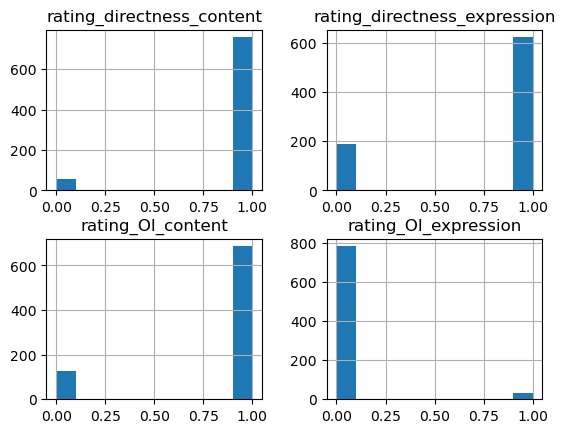

In [260]:
df_labeled_utterances.filter(like="rating").hist() ### our distributions are a little skewed towards being direct but not very intense

In [261]:
# this means we need to do some balancing...
def per_column_balanced_dfs(df, label_columns, sample_pct = 0.7, seed=42):
	np.random.seed(seed)
	balanced_dfs = {}
	for col in label_columns:
		zeros = df[df[col] == 0]
		ones = df[df[col] == 1]
		n = int(min(len(zeros), len(ones)) * sample_pct)
		if n == 0:
			balanced_dfs[col] = pd.DataFrame(columns=df.columns)
		else:
			balanced = pd.concat([
				zeros.sample(n, random_state=seed),
				ones.sample(n, random_state=seed)
			]).sample(frac=1, random_state=seed).reset_index(drop=True)
			balanced_dfs[col] = balanced
	return balanced_dfs

dfs = per_column_balanced_dfs(df_labeled_utterances, [
		"rating_directness_content",
		"rating_directness_expression",
		"rating_OI_content",
		"rating_OI_expression"
	], seed=42)

for col, dfx in dfs.items():
	print(col, dfx[col].value_counts())

rating_directness_content rating_directness_content
0    38
1    38
Name: count, dtype: int64
rating_directness_expression rating_directness_expression
1    131
0    131
Name: count, dtype: int64
rating_OI_content rating_OI_content
0    88
1    88
Name: count, dtype: int64
rating_OI_expression rating_OI_expression
1    21
0    21
Name: count, dtype: int64


#### Can we predict directness and oppositional intensity?

In [262]:
df_labeled_utterances['text'] = df_labeled_utterances['text'].astype(str)
df_labeled_utterances.sort_values(by=['CONV_ID', 'id', 'timestamp'], inplace=True)
df_labeled_utterances['timestamp'] = pd.to_datetime(df_labeled_utterances['timestamp'], unit='ns', utc=True)
df_labeled_utterances.reset_index(drop=True, inplace=True)

In [263]:
try:
	df_utterances_featurized = pd.read_csv('output/chat/labeled_utterances_reddit_chat_level.csv')

except FileNotFoundError:
	# first, run the feature builder on the labeled utterances
	labeled_reddit_feature_builder = FeatureBuilder(
		input_df=df_labeled_utterances,
		custom_features=[
			"(BERT) Mimicry",
			"Moving Mimicry",
			"Forward Flow",
			"Discursive Diversity"
		],
		conversation_id_col="CONV_ID",
		speaker_id_col="speaker",
		message_col="text",
		timestamp_col="timestamp",
		vector_directory="./vector_data/",
		output_file_base="labeled_utterances_reddit",
		timestamp_unit='ns'    
	)
	labeled_reddit_feature_builder.featurize()

In [271]:
BOOTSTRAPS = 1000
BASE_SEED = 42

outcomes = [
	"rating_directness_content", 
	"rating_directness_expression",
	"rating_OI_content", 
	"rating_OI_expression"
]

try:
	# load existing results if available
	with open('output/predict_utt_labels_coef_dfs.pkl', 'rb') as f:
		coef_dfs = pickle.load(f)
		print(f"Loaded {len(coef_dfs)} coefficient dataframes from previous runs.")
	with open('output/predict_utt_labels_results.pkl', 'rb') as f:
		results = pickle.load(f)
		print(f"Loaded {len(results)} results from previous runs.")
	with open('output/predict_utt_labels_model_records.pkl', 'rb') as f:
		model_records = pickle.load(f)
		print(f"Loaded {len(model_records)} model records from previous runs.")
except Exception as e:
	
	print("Could not load pickled results:", e)
	results = []
	coef_dfs = []
	model_records = []

	for i in tqdm(range(BOOTSTRAPS), desc="Bootstrapping CV's"):
		# Get a new random sample of balanced dataframes for each outcome on this bootstrap
		dfs = per_column_balanced_dfs(df_labeled_utterances, outcomes, seed=BASE_SEED + i)

		for outcome in outcomes:
			# The balanced df for this outcome, must merge with features on 'id'
			sample = dfs[outcome]
			if sample.empty or sample[outcome].nunique() < 2:
				continue

			# Merge with features
			merged = sample.merge(df_utterances_featurized[['id'] + CHAT_LEVEL_FEATURES], on='id', how='inner')

			# In every iteration, train on 80% and test on 20%
			X = merged[CHAT_LEVEL_FEATURES]
			y = merged[outcome]
			X_train, X_test, y_train, y_test = train_test_split(
				X, y, test_size=0.2, random_state=BASE_SEED + i, stratify=y
			)

			model = Pipeline([
				('scaler', StandardScaler()),  # Standardize features
				('clf', LogisticRegressionCV(
					cv=5,
					max_iter=2000,
					random_state=BASE_SEED + i,
					penalty='elasticnet',
					l1_ratios=[.2, .5, .8, 1.0],
					scoring='f1',
					n_jobs=-1,
					solver='saga',
					Cs=10,  # Cross-validate over 10 strengths for C (inverse regularization)
					refit=True
				))
			])

			try:
				model.fit(X_train, y_train)
				y_pred = model.predict(X_test)

				# Save the model and predictions for this bootstrap
				model_records.append({
					'outcome': outcome,
					'bootstrap': i,
					'model': model,
					'X_test': X_test,
					'y_test': y_test,
					'y_pred': y_pred
				})
				# Save F1 score and coefficients
				f1 = f1_score(y_test, y_pred)
				results.append({
					'outcome': outcome,
					'bootstrap': i,
					'f1_score': f1
				})
				coefs = model.named_steps['clf'].coef_.ravel()
				coef_df = pd.DataFrame({
					'feature': CHAT_LEVEL_FEATURES,
					'coef': coefs,
					'outcome': outcome,
					'bootstrap': i
				})
				coef_dfs.append(coef_df)
			except Exception as e:
				print(f"Error training model for outcome {outcome} on bootstrap {i}: {e}")
				continue

Loaded 4000 coefficient dataframes from previous runs.
Loaded 4000 results from previous runs.
Could not load pickled results: [Errno 2] No such file or directory: 'output/predict_utt_labels_model_records.pkl'


Bootstrapping CV's: 100%|██████████| 1000/1000 [1:24:44<00:00,  5.08s/it]


In [272]:
# save coef_dfs and results to pkl files
with open('output/predict_utt_labels_coef_dfs.pkl', 'wb') as f:
	pickle.dump(coef_dfs, f)
with open('output/predict_utt_labels_results.pkl', 'wb') as f:
	pickle.dump(results, f)
with open('output/predict_utt_labels_model_records.pkl', 'wb') as f:
    pickle.dump(model_records, f)

print("saved results and coefficient dataframes.")

saved results and coefficient dataframes.


In [266]:
# Combine and summarize
coef_long = pd.concat(coef_dfs, ignore_index=True)
f1_df = pd.DataFrame(results)

pretty_names = {
	"rating_directness_expression": "Directness (Expression)",
	"rating_directness_content": "Directness (Content)",
	"rating_OI_expression": "Oppositional Intensity (Expression)",
	"rating_OI_content": "Oppositional Intensity (Content)"
}
coef_long["Label"] = coef_long["outcome"].map(pretty_names)
f1_df["Label"] = f1_df["outcome"].map(pretty_names)

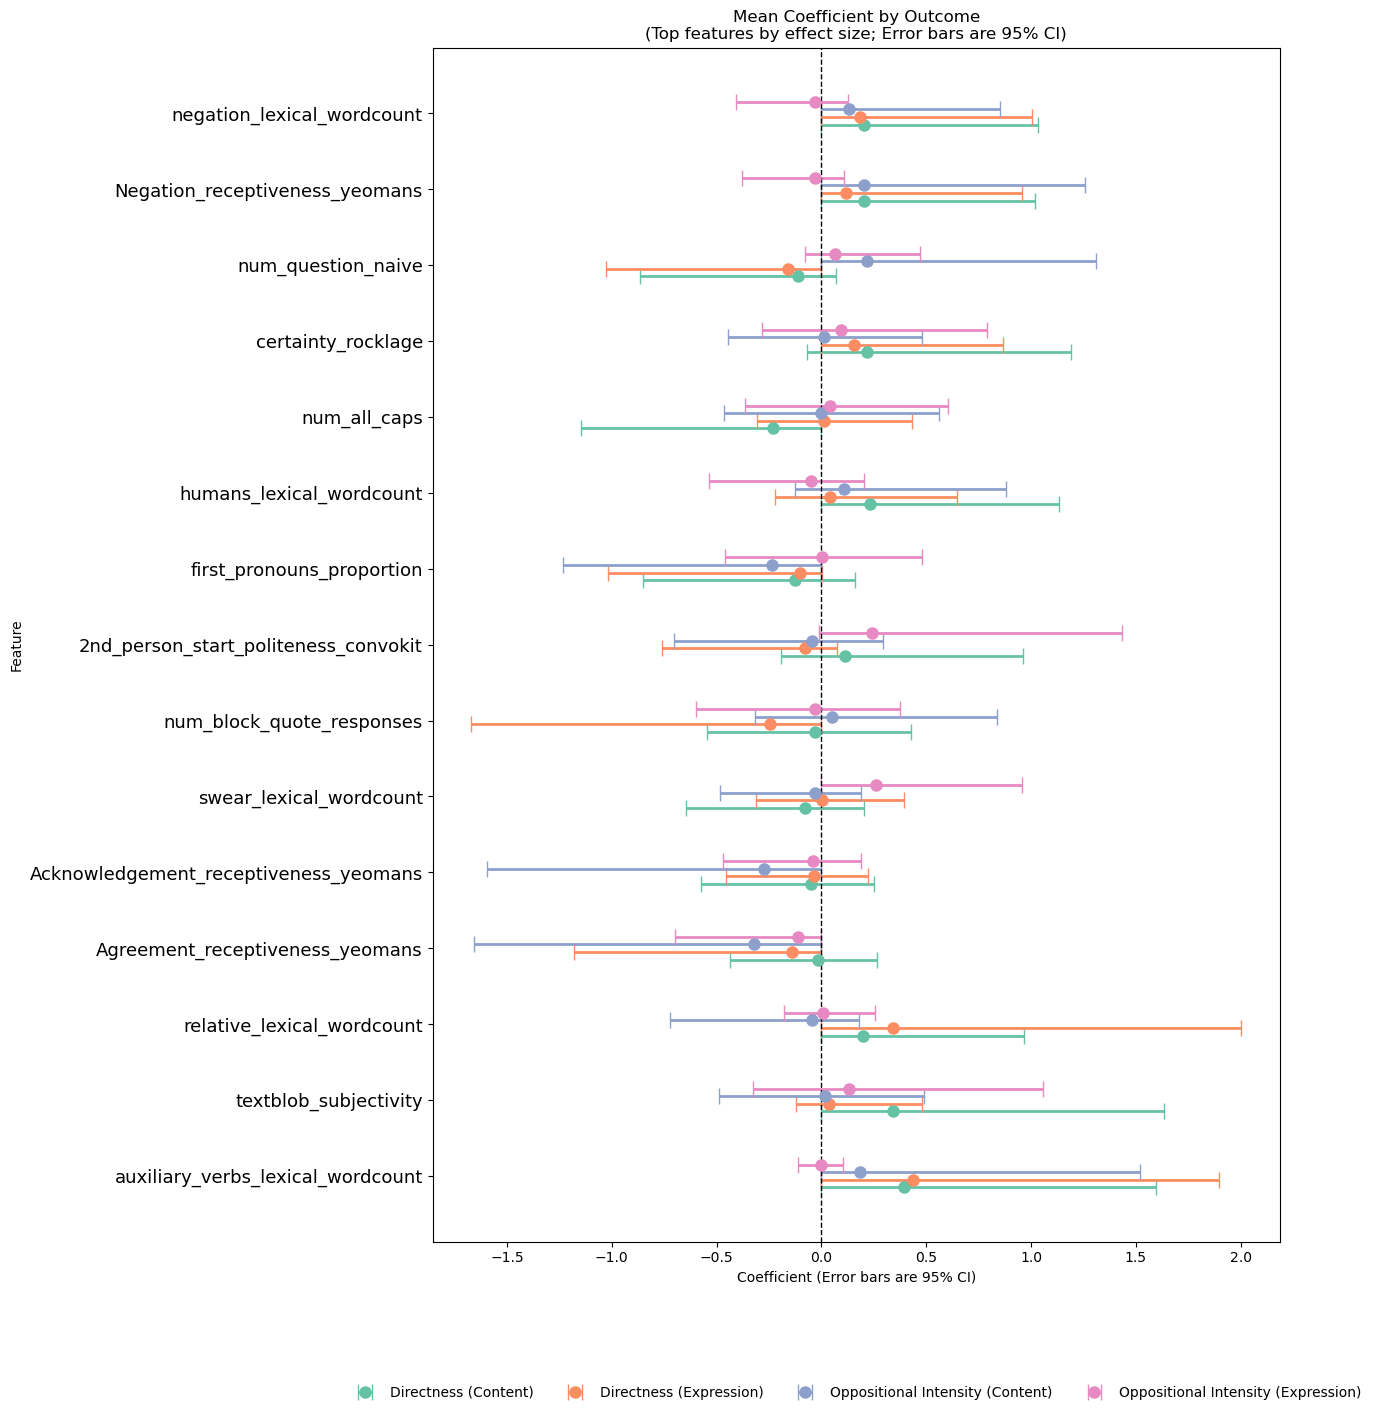

In [275]:
# 1. Significance filter: features with at least one label significantly different from zero
interesting_features = []
for feature in coef_long['feature'].unique():
	keep = False
	for label in coef_long['Label'].unique():
		data = coef_long[(coef_long['feature'] == feature) & (coef_long['Label'] == label)]['coef']
		if len(data) > 1:
			tstat, pval = ttest_1samp(data, popmean=0)
			if pval < 0.05:
				keep = True
	if keep:
		interesting_features.append(feature)

# 2. Subset to just those features, but ensure every (feature, Label) pair appears (even if no data there)
features_to_plot = interesting_features
labels_to_plot = list(coef_long["Label"].unique())
n_labels = len(labels_to_plot)

pad = []
for feature in features_to_plot:
	for label in labels_to_plot:
		mask = (coef_long['feature']==feature) & (coef_long['Label']==label)
		if not mask.any():
			pad.append({
				"feature": feature,
				"coef": np.nan,
				"Label": label
			})
coef_plot = pd.concat([coef_long[coef_long['feature'].isin(features_to_plot)], pd.DataFrame(pad)], ignore_index=True)

# Compute means and standard errors for each (feature, Label)
summary = coef_plot.groupby(['feature', 'Label'])['coef'].agg(['mean', 'sem']).reset_index()

# Same ordering logic: order by max |mean| across labels, desc
means_wide = summary.pivot(index='feature', columns='Label', values='mean')
ordering = means_wide.abs().max(axis=1).sort_values(ascending=False).index[:15].tolist()
summary = summary[summary['feature'].isin(ordering)]
summary['feature'] = pd.Categorical(summary['feature'], categories=ordering, ordered=True)

plt.figure(figsize=(13, max(8, len(ordering))))

hue_names = list(summary['Label'].unique())
palette = sns.color_palette("Set2", n_colors=len(hue_names))
label_to_color = dict(zip(hue_names, palette))
hue_offsets = np.linspace(-0.15, 0.15, len(hue_names))  # for y-axis jitter to prevent overlap

# Error bars = 1 standard error (SE) of the mean
# for i, feature in enumerate(ordering):
# 	for j, label in enumerate(hue_names):
# 		row = summary[(summary['feature']==feature)&(summary['Label']==label)]
# 		if row.shape[0]:
# 			mu = row['mean'].values[0]
# 			se = row['sem'].values[0]
# 			plt.errorbar(
# 				mu, i + hue_offsets[j], xerr=se, fmt='o',
# 				color=label_to_color[label],
# 				label=label if i == 0 else "",
# 				capsize=6, markersize=8, elinewidth=2
# 			)
# Error bars = 95% CI
for i, feature in enumerate(ordering):
    for j, label in enumerate(hue_names):
        # Extract all bootstrap coef values
        this_vals = coef_plot[(coef_plot['feature']==feature)&(coef_plot['Label']==label)]['coef'].dropna()
        if len(this_vals):
            mu = this_vals.mean()
            ci_low = np.percentile(this_vals, 2.5)
            ci_high = np.percentile(this_vals, 97.5)
            # Error bar is asymmetric: (low, high)
            err = np.array([[mu - ci_low], [ci_high - mu]])
            plt.errorbar(
                mu, i + hue_offsets[j], xerr=err, fmt='o',
                color=label_to_color[label],
                label=label if i == 0 else "",
                capsize=6, markersize=8, elinewidth=2
            )

plt.axvline(0, color='black', lw=1, linestyle='--')
plt.yticks(range(len(ordering)), ordering, fontsize=13)
plt.xlabel("Coefficient (Error bars are 95% CI)") # plt.xlabel("Coefficient (mean ± 1 SE)")
plt.ylabel("Feature")
plt.title("Mean Coefficient by Outcome\n(Top features by effect size; Error bars are 95% CI)")
# plt.title("Mean Coefficient (±1 SE) by Outcome\n(Top features by effect size)")
plt.tight_layout(rect=[0, 0.13, 1, 1])
plt.legend(
	title="", loc='upper center',
	bbox_to_anchor=(0.5, -0.11),
	ncol=len(hue_names), frameon=False
)
plt.show()

#### F1 Plot

In [273]:
# For each label, collect all y_test and y_pred into one big array
global_f1s = []

# Get list of labels/outcomes (better to extract from model_records for robustness)
all_labels = sorted(set(rec['outcome'] for rec in model_records))
pretty_name_map = pretty_names  # already defined

for label in all_labels:
    y_true_all = []
    y_pred_all = []
    for rec in model_records:
        if rec['outcome'] == label:
            y_true_all.append(np.array(rec['y_test']))  # cast for safety; may be pandas or np
            y_pred_all.append(np.array(rec['y_pred']))
    # Concatenate all test set true and preds
    if y_true_all:
        y_true_concat = np.concatenate(y_true_all)
        y_pred_concat = np.concatenate(y_pred_all)
        f1_global = f1_score(y_true_concat, y_pred_concat)
        global_f1s.append(dict(
            Label=pretty_name_map.get(label, label),
            global_f1=f1_global,
            n_test=len(y_true_concat)
        ))
    else:
        global_f1s.append(dict(Label=pretty_name_map.get(label, label), global_f1=np.nan, n_test=0))

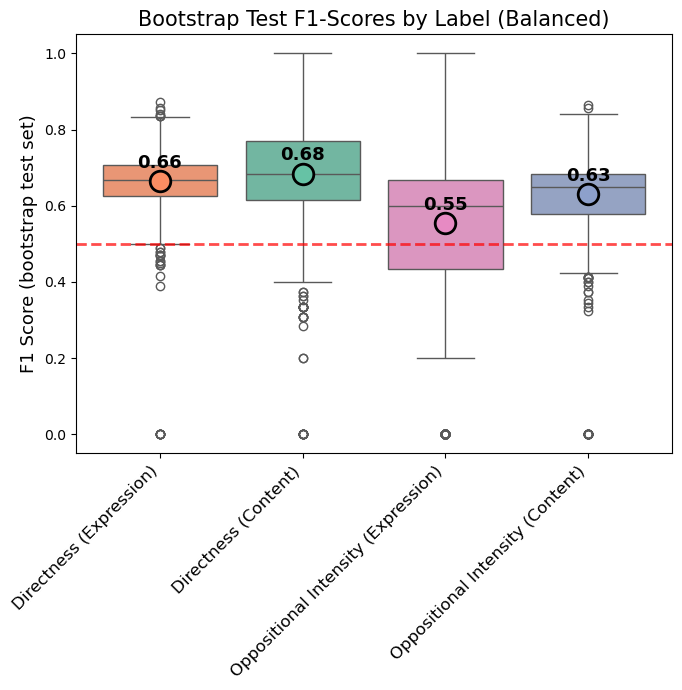

In [274]:
global_f1_df = pd.DataFrame(global_f1s)

plt.figure(figsize=(7,7))
box = sns.boxplot(
	data=f1_df, 
	x='Label', y='f1_score', 
	order=pretty_names.values(),
	palette=label_to_color
)
plt.axhline(0.5, color='red', linestyle='--', lw=2, alpha=0.7)

# Overlay global F1 points for each outcome/label
for i, label in enumerate(pretty_names.values()):
    val = global_f1_df[global_f1_df['Label'] == label]['global_f1'].iloc[0]
    plt.scatter(
        i, val, 
        marker='o', 
        color=label_to_color[label], 
        s=220, linewidth=2, edgecolor='k', zorder=5,
        label=f'Global F1: {val:.2f}' if not np.isnan(val) else 'Global F1: NA'
    )
    # Add text label on top
    if not np.isnan(val):
        plt.text(
            i, val+0.035, 
            f"{val:.2f}", 
            color='k', fontsize=13, fontweight='bold', ha='center'
        )

plt.ylabel('F1 Score (bootstrap test set)', fontsize=13)
plt.xlabel('')
plt.title('Bootstrap Test F1-Scores by Label (Balanced)', fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.tight_layout()
plt.show()

#### conversation level (outcomes)

In [ ]:
# TODO: now use the features to predict the outcome (escalatory or de-escalatory) of the conversation

#### Use XGboost to predict conflict outcomes using text-based features

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import shap
import matplotlib.pyplot as plt

def xgboost_classification_2(df, dependent_var, independent_vars): # note potential issues here
	# Replace `inf` and `-inf` with NaN and then fill with 0
	df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
	
	X = df[independent_vars]
	y = df[dependent_var]
	
	# 80:20 train-test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	
	# Initialize and train the model
	model = xgb.XGBClassifier()
	model.fit(X_train, y_train)
	
	# Make predictions
	y_pred = model.predict(X_test)

	# Explain model predictions with SHAP
	explainer = shap.TreeExplainer(model)
	shap_values = explainer.shap_values(X_test)

	plt.figure()
	shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
	plt.show()
	
	# Evaluation metrics for each class
	f1 = f1_score(y_test, y_pred, average=None)
	precision = precision_score(y_test, y_pred, average=None)
	recall = recall_score(y_test, y_pred, average=None)
	
	# Data for the table
	table_data = [
		["Metric", "Low", "High"],
		["F1", f"{f1[0]:.2f}", f"{f1[1]:.2f}"],
		["Precision", f"{precision[0]:.2f}", f"{precision[1]:.2f}"],
		["Recall", f"{recall[0]:.2f}", f"{recall[1]:.2f}"],
	]

	# Define column widths
	col_widths = [max(len(row[i]) for row in table_data) for i in range(len(table_data[0]))]

	# Print the table
	print(f"Metrics for predicting {dependent_var} using XGBoost\n")
	print("-" * (sum(col_widths) + len(col_widths) * 3))  # Print the top border
	for row in table_data:
		print(" | ".join(f"{cell:{col_widths[i]}}" for i, cell in enumerate(row)))
		print("-" * (sum(col_widths) + len(col_widths) * 3))  # Print the border between rows


### Reddit Data

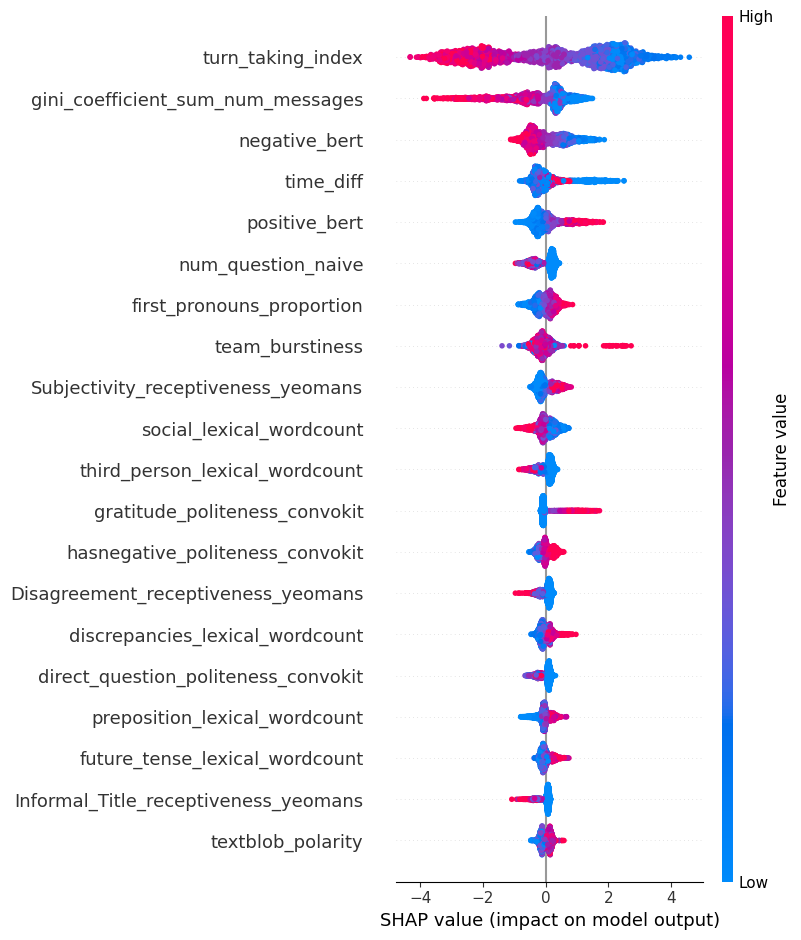

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.88 | 0.88
--------------------------
Precision | 0.88 | 0.88
--------------------------
Recall    | 0.87 | 0.88
--------------------------


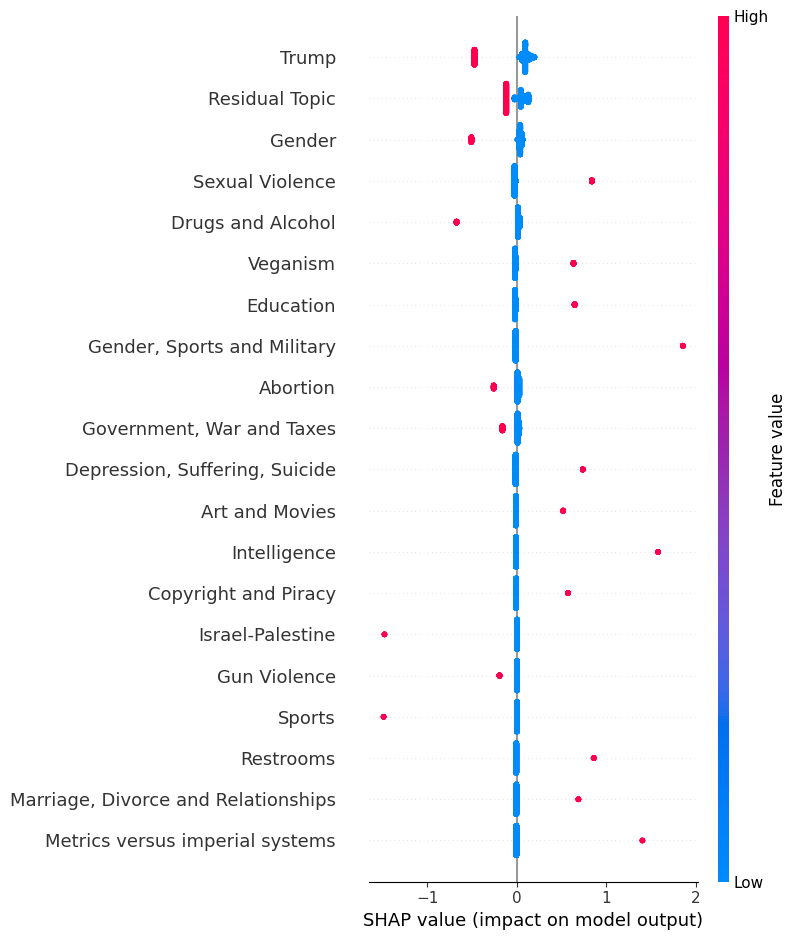

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.67 | 0.47
--------------------------
Precision | 0.56 | 0.68
--------------------------
Recall    | 0.83 | 0.36
--------------------------


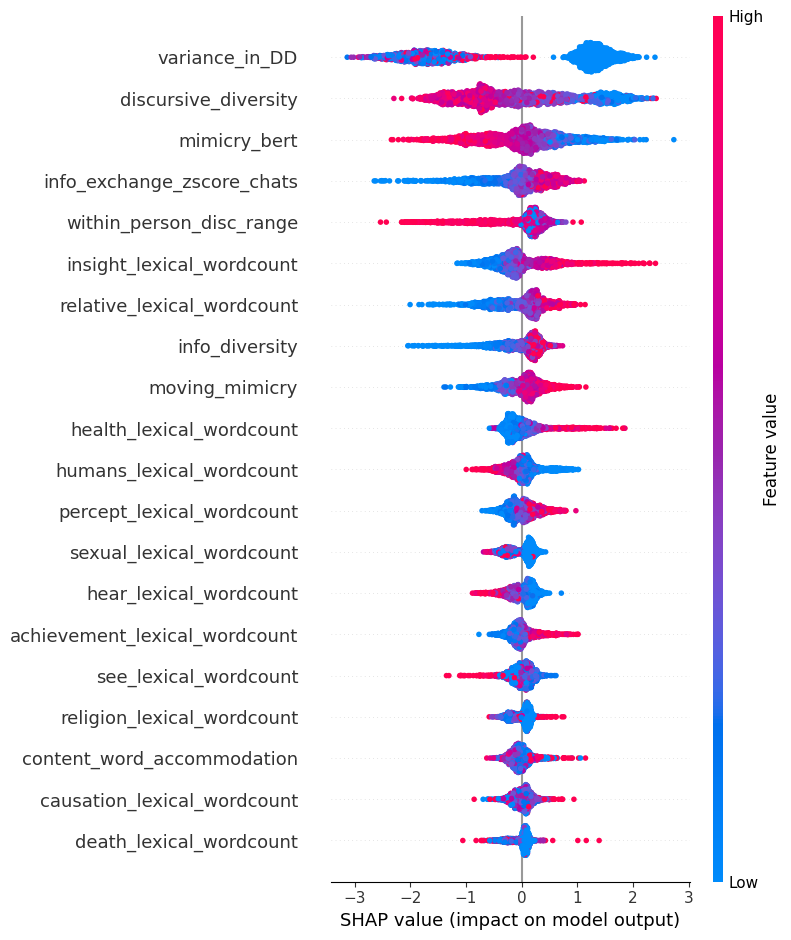

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.82 | 0.82
--------------------------
Precision | 0.82 | 0.82
--------------------------
Recall    | 0.81 | 0.83
--------------------------


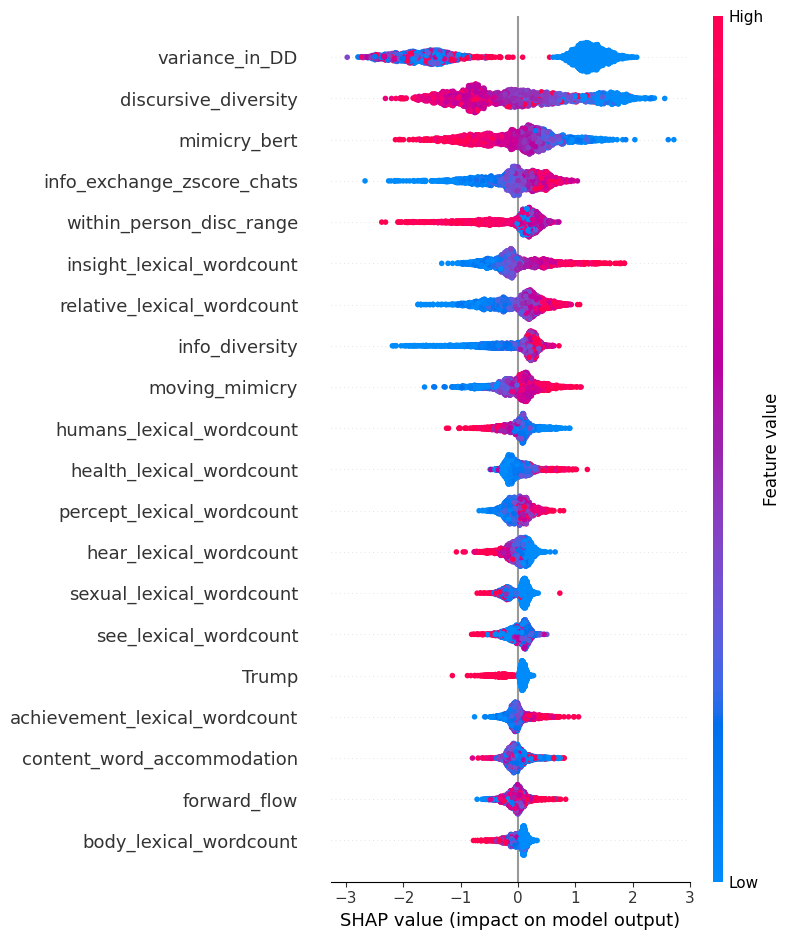

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.82 | 0.82
--------------------------
Precision | 0.82 | 0.82
--------------------------
Recall    | 0.81 | 0.83
--------------------------


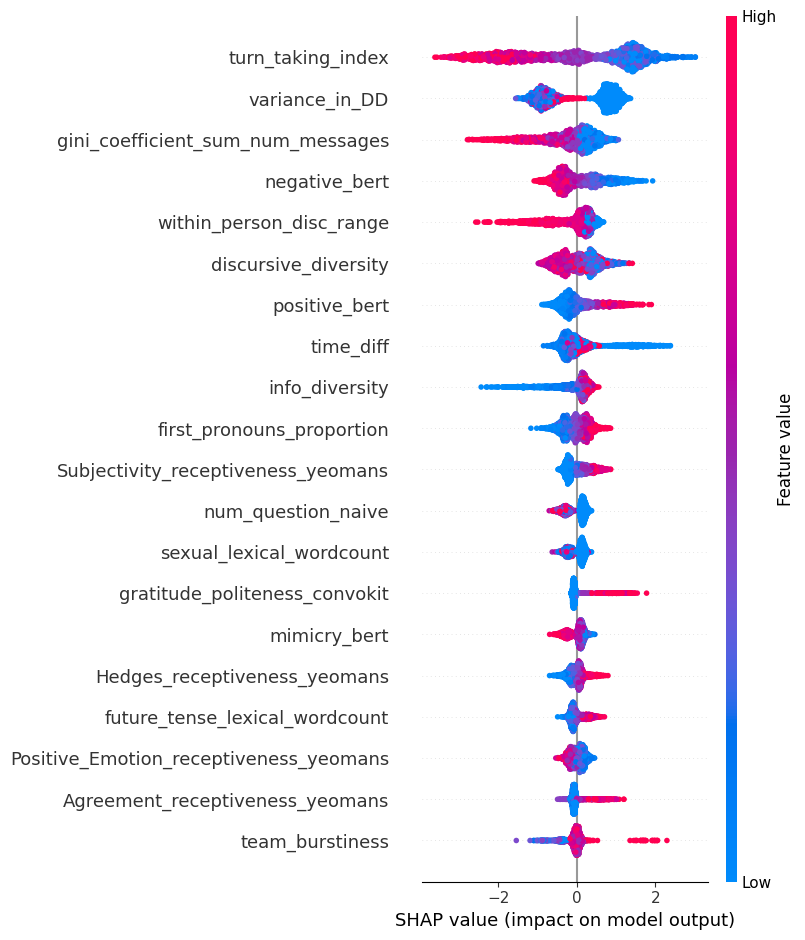

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.88 | 0.88
--------------------------
Precision | 0.88 | 0.88
--------------------------
Recall    | 0.87 | 0.89
--------------------------


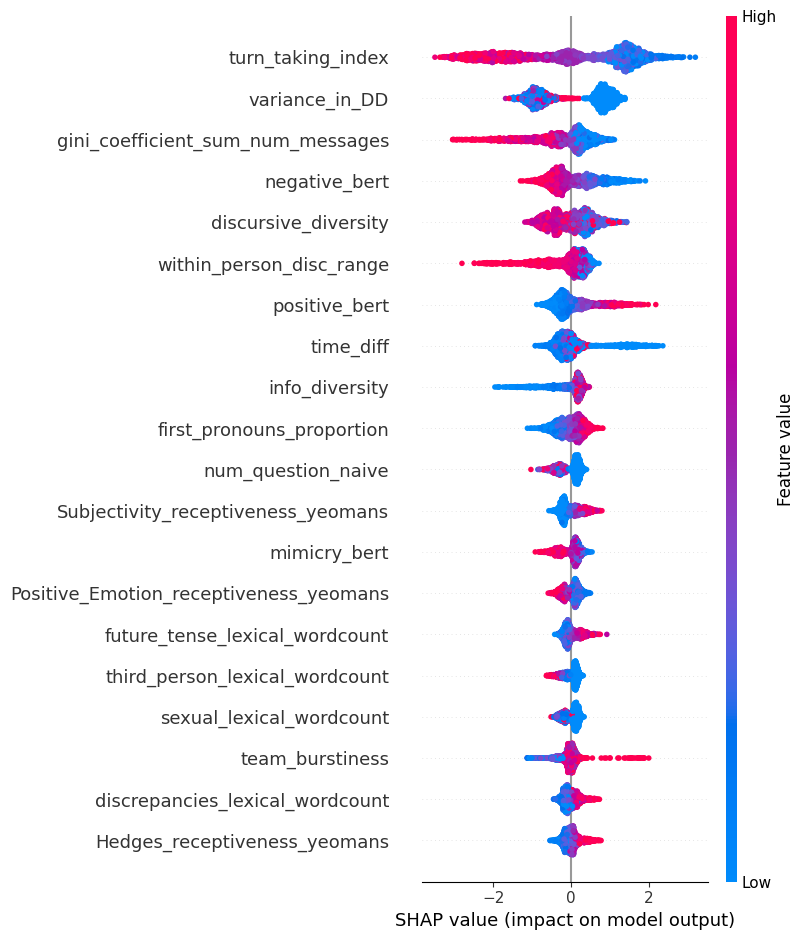

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.88 | 0.89
--------------------------
Precision | 0.89 | 0.88
--------------------------
Recall    | 0.87 | 0.89
--------------------------


In [ ]:
xgboost_classification_2(reddit_combined,'outcome',EXPRESSION_ONLY_1)
xgboost_classification_2(reddit_combined,'outcome',CONTENT_TOPICS_ONLY_2)
xgboost_classification_2(reddit_combined,'outcome',CONTENT_SEMANTIC_ONLY_3)
xgboost_classification_2(reddit_combined,'outcome',CONTENT_TOPICS_AND_SEMANTIC_4)
xgboost_classification_2(reddit_combined,'outcome',EXPRESSION_AND_SEMANTIC_SIMILARITY_5)
xgboost_classification_2(reddit_combined,'outcome',ALL_FEATURES_6)

### GPT generated data

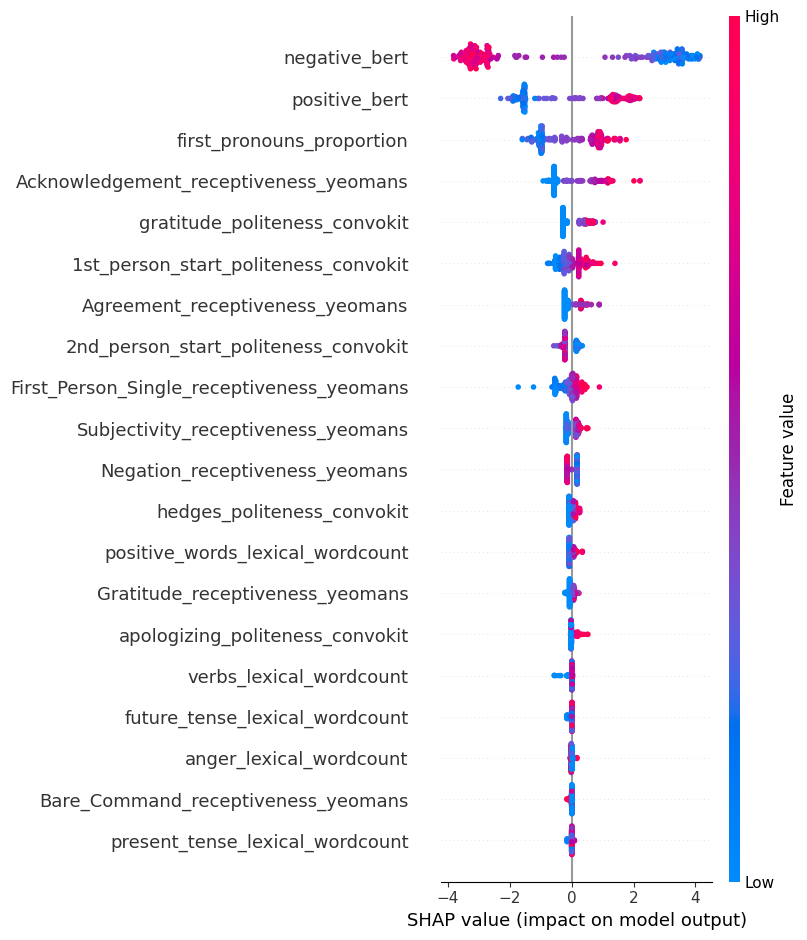

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.99 | 0.99
--------------------------
Precision | 0.98 | 1.00
--------------------------
Recall    | 1.00 | 0.98
--------------------------


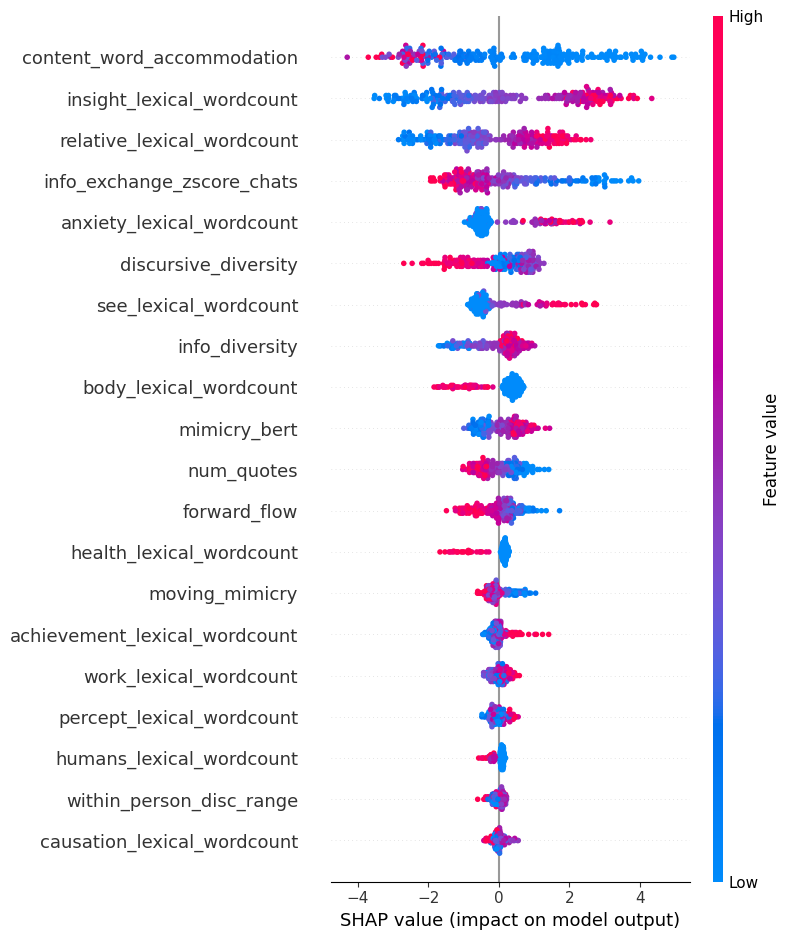

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.89 | 0.89
--------------------------
Precision | 0.90 | 0.89
--------------------------
Recall    | 0.88 | 0.90
--------------------------


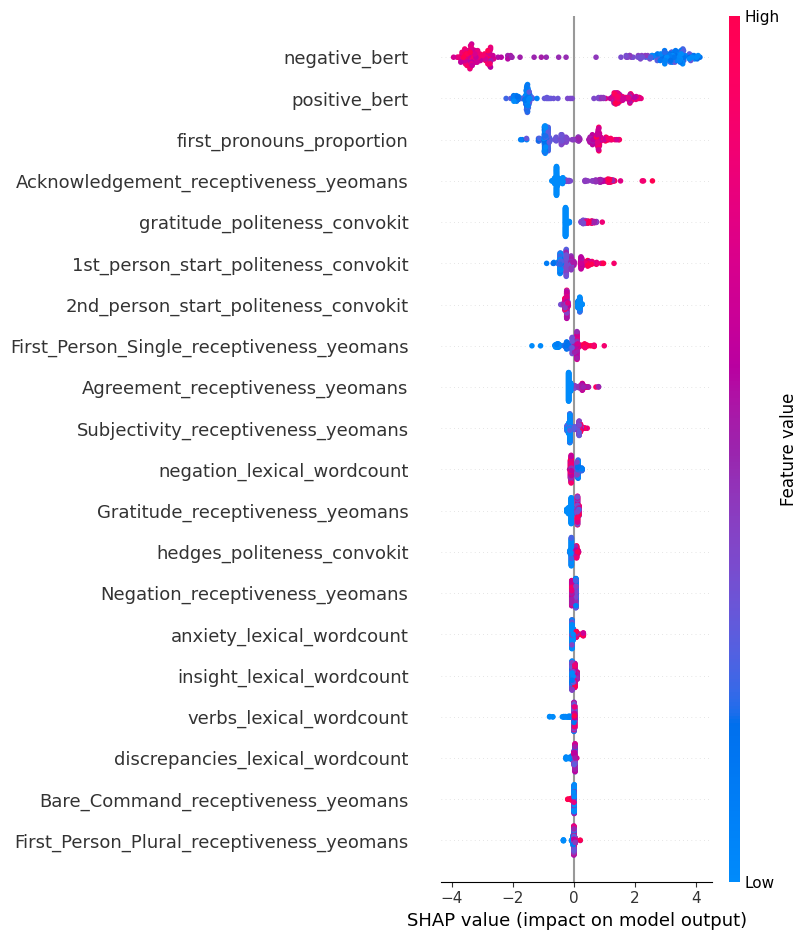

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.99 | 0.99
--------------------------
Precision | 0.98 | 1.00
--------------------------
Recall    | 1.00 | 0.98
--------------------------


In [ ]:
xgboost_classification_2(gpt_combined,'outcome',EXPRESSION_ONLY_1)
xgboost_classification_2(gpt_combined,'outcome',CONTENT_SEMANTIC_ONLY_3)
xgboost_classification_2(gpt_combined,'outcome',EXPRESSION_AND_SEMANTIC_SIMILARITY_5)